Decision trees

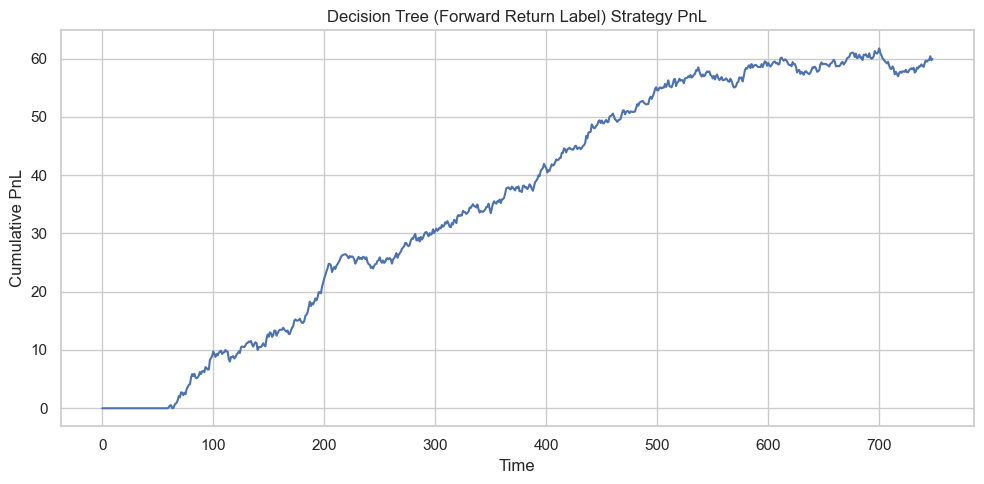

Total PnL: 59.95
Average Daily Return: 0.0800
Volatility: 0.4214
Sharpe Ratio: 3.01
Max Drawdown: 4.77


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Load prices
data = np.loadtxt("prices.txt", dtype=float).T
p1, p2 = data[0], data[1]  # Example pair

# Helper to compute spread and z-score
def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

# Enhanced strategy using forward returns as label
def enhanced_tree_strategy_with_return_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []

    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)

        # Features
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0

        forward_return = spread[t + 5] - spread[t]
        if forward_return > 0.002:
            label = 1
        elif forward_return < -0.002:
            label = -1
        else:
            label = 0

        features = [
            z[t],
            mean,
            std,
            momentum_3,
            momentum_5,
            spread[t] - spread[t - 1],
            upper_band - spread[t],
            spread[t] - lower_band,
            vol_regime
        ]

        X.append(features)
        y.append(label)

    clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    clf.fit(X, y)

    # Predict positions
    positions = [0] * window
    for t in range(window, len(z) - 1):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0

        test_feat = [
            z[t],
            mean,
            std,
            momentum_3,
            momentum_5,
            spread[t] - spread[t - 1],
            upper_band - spread[t],
            spread[t] - lower_band,
            vol_regime
        ]
        pred = clf.predict([test_feat])[0]
        positions.append(pred)

    positions.append(0)
    return np.array(positions), spread

# Run strategy
positions, spread = enhanced_tree_strategy_with_return_labels(p1, p2)
spread_diff = np.diff(spread)
pnl = positions[:-1] * spread_diff
cumulative_pnl = np.cumsum(pnl)

# Metrics
total_pnl = cumulative_pnl[-1]
avg_daily_return = pnl.mean()
volatility = pnl.std()
sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
max_drawdown = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_pnl)
plt.title("Decision Tree (Forward Return Label) Strategy PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
print(f"Total PnL: {total_pnl:.2f}")
print(f"Average Daily Return: {avg_daily_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")


ensemble decision trees

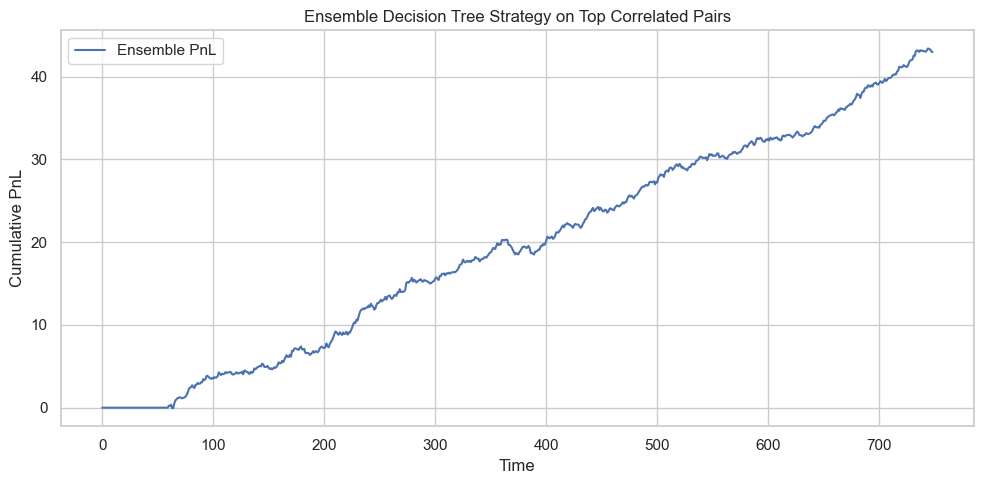

Total PnL: 42.97
Average Daily Return: 0.0574
Volatility: 0.1906
Sharpe Ratio: 4.78
Max Drawdown: 1.80


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# Load and transpose prices
data = np.loadtxt("prices.txt", dtype=float).T
n_assets = data.shape[0]

# Identify top correlated pairs
returns = np.diff(np.log(data), axis=1)
cor_matrix = np.corrcoef(returns)
pairs = []
for i in range(n_assets):
    for j in range(i + 1, n_assets):
        pairs.append(((i, j), cor_matrix[i, j]))
pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
top_pairs = pairs[:5]
pair_indices = [pair[0] for pair in top_pairs]

# Function to compute spread and z-score
def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

# Train decision tree with forward returns as labels
def train_decision_tree_with_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []

    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0
        forward_return = spread[t + 5] - spread[t]
        label = 1 if forward_return > 0.002 else -1 if forward_return < -0.002 else 0

        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band, vol_regime
        ]
        X.append(features)
        y.append(label)

    clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    clf.fit(X, y)
    return clf, spread, z

# Ensemble prediction
min_len = min([len(data[i]) for i, j in pair_indices] + [len(data[j]) for i, j in pair_indices])
ensemble_positions = np.zeros(min_len - 1)

for i, j in pair_indices:
    p1, p2 = data[i][:min_len], data[j][:min_len]
    clf, spread, z = train_decision_tree_with_labels(p1, p2)
    spread = np.array(spread)
    positions = [0] * 60

    for t in range(60, len(z) - 1):
        spread_window = spread[t - 20:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0

        test_feat = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band, vol_regime
        ]
        pred = clf.predict([test_feat])[0]
        positions.append(pred)

    positions = np.array(positions[:len(spread) - 1])
    spread_diff = np.diff(spread)
    pnl = positions * spread_diff
    ensemble_positions[:len(pnl)] += pnl

# Final PnL and metrics
ensemble_pnl = ensemble_positions / len(top_pairs)
cumulative_pnl = np.cumsum(ensemble_pnl)
total_pnl = cumulative_pnl[-1]
avg_daily_return = ensemble_pnl.mean()
volatility = ensemble_pnl.std()
sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
max_drawdown = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(cumulative_pnl, label="Ensemble PnL")
plt.title("Ensemble Decision Tree Strategy on Top Correlated Pairs")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print(f"Total PnL: {total_pnl:.2f}")
print(f"Average Daily Return: {avg_daily_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")


Extend to random forest

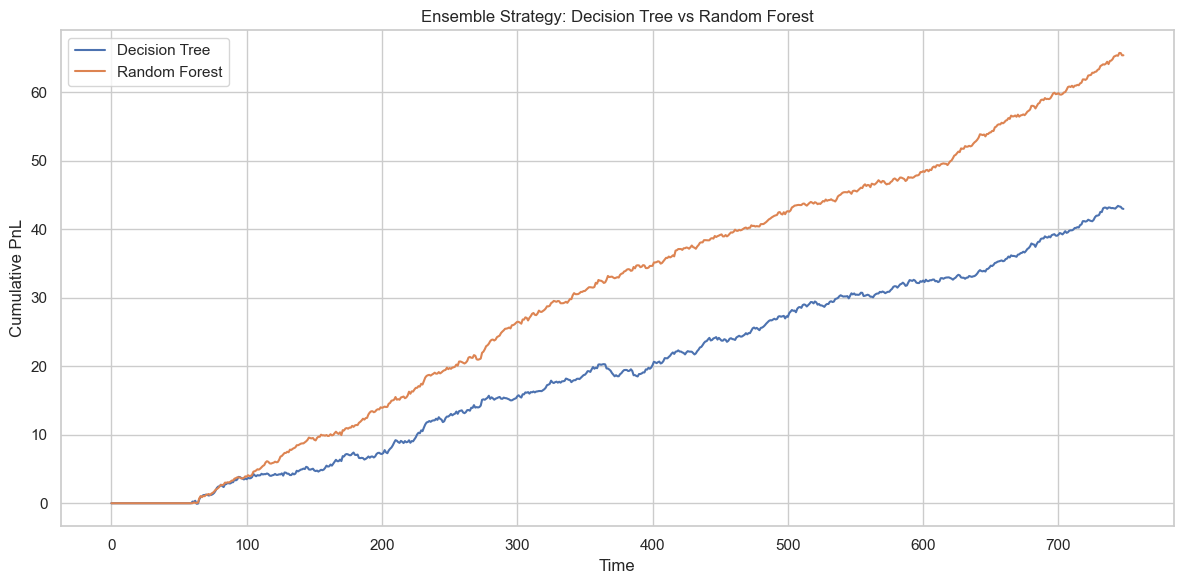

Model             Total PnL    Avg Daily Return     Volatility   Sharpe Ratio        Max Drawdown
Decision Tree         42.97              0.0574         0.1906           4.78                1.80
Random Forest         65.40              0.0873         0.1860           7.45                0.67


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Load price data
data = np.loadtxt("prices.txt", dtype=float).T
n_assets = data.shape[0]

# Identify top correlated pairs
returns = np.diff(np.log(data), axis=1)
cor_matrix = np.corrcoef(returns)
pairs = [((i, j), cor_matrix[i, j]) for i in range(n_assets) for j in range(i + 1, n_assets)]
top_pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)[:5]
pair_indices = [pair[0] for pair in top_pairs]

min_len = min([len(data[i]) for i, j in pair_indices] + [len(data[j]) for i, j in pair_indices])

# Spread & z-score computation
def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

# Training function
def train_model_with_labels(p1, p2, model='tree', window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []

    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0
        forward_return = spread[t + 5] - spread[t]
        label = 1 if forward_return > 0.002 else -1 if forward_return < -0.002 else 0

        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band, vol_regime
        ]
        X.append(features)
        y.append(label)

    if model == 'rf':
        clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    else:
        clf = DecisionTreeClassifier(max_depth=5, random_state=42)

    clf.fit(X, y)
    return clf, spread, z

# Strategy runner
def run_ensemble(pair_indices, model='tree'):
    ensemble_positions = np.zeros(min_len - 1)
    for i, j in pair_indices:
        p1, p2 = data[i][:min_len], data[j][:min_len]
        clf, spread, z = train_model_with_labels(p1, p2, model=model)
        spread = np.array(spread)
        positions = [0] * 60

        for t in range(60, len(z) - 1):
            spread_window = spread[t - 20:t]
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            upper_band = mean + 2 * std
            lower_band = mean - 2 * std
            momentum_3 = spread[t] - spread[t - 3]
            momentum_5 = spread[t] - spread[t - 5]
            long_vol = np.std(spread[t - 40:t])
            short_vol = np.std(spread[t - 10:t])
            vol_regime = 1 if short_vol > long_vol else 0

            test_feat = [
                z[t], mean, std, momentum_3, momentum_5,
                spread[t] - spread[t - 1], upper_band - spread[t],
                spread[t] - lower_band, vol_regime
            ]
            pred = clf.predict([test_feat])[0]
            positions.append(pred)

        positions = np.array(positions[:len(spread) - 1])
        spread_diff = np.diff(spread)
        pnl = positions * spread_diff
        ensemble_positions[:len(pnl)] += pnl

    return ensemble_positions / len(pair_indices)

# Run both models
pnl_tree = run_ensemble(pair_indices, model='tree')
pnl_rf = run_ensemble(pair_indices, model='rf')
cum_pnl_tree = np.cumsum(pnl_tree)
cum_pnl_rf = np.cumsum(pnl_rf)

# Metrics
def evaluate(pnl_series):
    cum = np.cumsum(pnl_series)
    total = cum[-1]
    avg = pnl_series.mean()
    vol = pnl_series.std()
    sharpe = avg / vol * np.sqrt(252) if vol else 0
    mdd = (np.maximum.accumulate(cum) - cum).max()
    return total, avg, vol, sharpe, mdd

metrics_tree = evaluate(pnl_tree)
metrics_rf = evaluate(pnl_rf)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl_tree, label="Decision Tree")
plt.plot(cum_pnl_rf, label="Random Forest")
plt.title("Ensemble Strategy: Decision Tree vs Random Forest")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
headers = ["Model", "Total PnL", "Avg Daily Return", "Volatility", "Sharpe Ratio", "Max Drawdown"]
print(f"{headers[0]:<15}{headers[1]:>12}{headers[2]:>20}{headers[3]:>15}{headers[4]:>15}{headers[5]:>20}")
print(f"{'Decision Tree':<15}{metrics_tree[0]:>12.2f}{metrics_tree[1]:>20.4f}{metrics_tree[2]:>15.4f}{metrics_tree[3]:>15.2f}{metrics_tree[4]:>20.2f}")
print(f"{'Random Forest':<15}{metrics_rf[0]:>12.2f}{metrics_rf[1]:>20.4f}{metrics_rf[2]:>15.4f}{metrics_rf[3]:>15.2f}{metrics_rf[4]:>20.2f}")


Gradient boosting

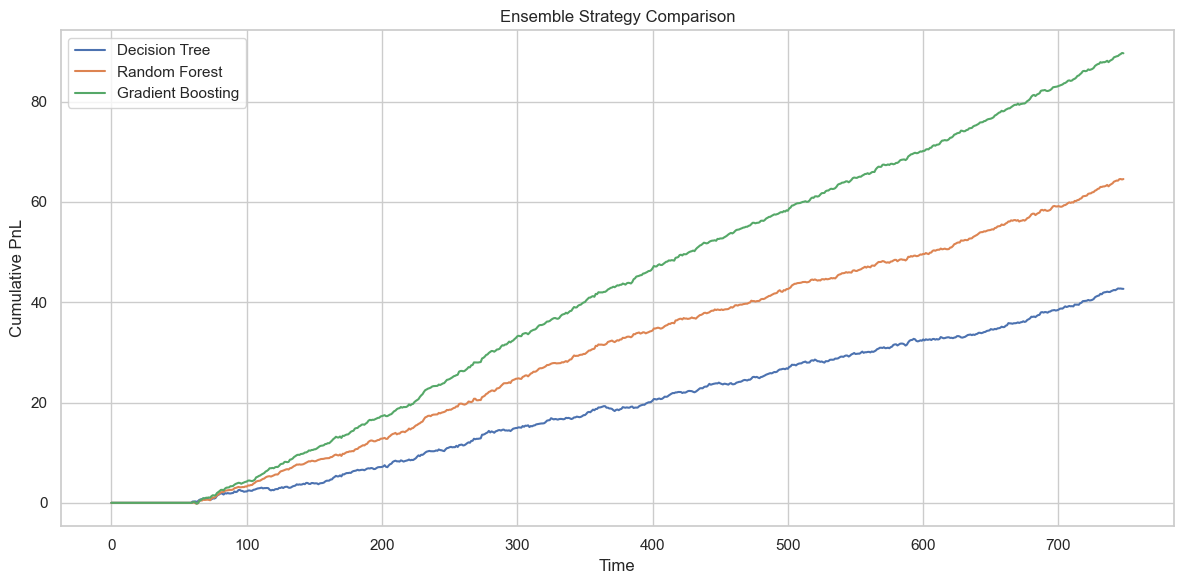

Tree: (42.674114445981196, 0.05697478564216443, 0.13641194176934887, 6.6302603066200785, 0.9678785602785247)
RF: (64.56894567981081, 0.08620687006650309, 0.13784988322859795, 9.92740512328159, 0.3454321324864438)
GB: (89.6483135852508, 0.11969067234345898, 0.14304752003282303, 13.282512826601128, 0.3490883702513443)


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and transpose price data
data = np.loadtxt("prices.txt", dtype=float).T
n_assets, n_obs = data.shape

# Compute log returns and correlation matrix
returns = np.diff(np.log(data), axis=1)
cor_matrix = np.corrcoef(returns)

def top_corr(cor_mat, top_n=10):
    n = cor_mat.shape[0]
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append(((i, j), cor_mat[i, j]))
    pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
    return pairs[:top_n]

top_pairs = top_corr(cor_matrix, top_n=10)
pair_indices = [pair for pair, _ in top_pairs]
min_len = min([len(data[i]) for i, j in pair_indices])

def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def evaluate(pnl):
    cum_pnl = np.cumsum(pnl)
    avg_daily_return = pnl.mean()
    volatility = pnl.std()
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
    max_drawdown = (np.maximum.accumulate(cum_pnl) - cum_pnl).max()
    return cum_pnl[-1], avg_daily_return, volatility, sharpe_ratio, max_drawdown

def generate_features_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []
    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0
        forward_return = spread[t + 5] - spread[t]
        label = 1 if forward_return > 0.002 else -1 if forward_return < -0.002 else 0
        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band, vol_regime
        ]
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y), spread, z

def run_ensemble_model(pair_indices, model_name='tree'):
    ensemble_positions = np.zeros(min_len - 1)
    for i, j in pair_indices:
        p1, p2 = data[i][:min_len], data[j][:min_len]
        X, y, spread, z = generate_features_labels(p1, p2)
        if model_name == 'rf':
            clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        elif model_name == 'gb':
            clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
        else:
            clf = DecisionTreeClassifier(max_depth=5, random_state=42)
        clf.fit(X, y)
        positions = [0] * 60
        for t in range(60, len(z) - 1):
            spread_window = spread[t - 20:t]
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            upper_band = mean + 2 * std
            lower_band = mean - 2 * std
            momentum_3 = spread[t] - spread[t - 3]
            momentum_5 = spread[t] - spread[t - 5]
            long_vol = np.std(spread[t - 40:t])
            short_vol = np.std(spread[t - 10:t])
            vol_regime = 1 if short_vol > long_vol else 0
            test_feat = [
                z[t], mean, std, momentum_3, momentum_5,
                spread[t] - spread[t - 1], upper_band - spread[t],
                spread[t] - lower_band, vol_regime
            ]
            pred = clf.predict([test_feat])[0]
            positions.append(pred)
        positions = np.array(positions[:len(spread) - 1])
        spread_diff = np.diff(spread)
        pnl = positions * spread_diff
        ensemble_positions[:len(pnl)] += pnl
    return ensemble_positions / len(pair_indices)

# Example:
pnl_tree = run_ensemble_model(pair_indices, model_name='tree')
pnl_rf = run_ensemble_model(pair_indices, model_name='rf')
pnl_gb = run_ensemble_model(pair_indices, model_name='gb')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pnl_tree), label="Decision Tree")
plt.plot(np.cumsum(pnl_rf), label="Random Forest")
plt.plot(np.cumsum(pnl_gb), label="Gradient Boosting")
plt.title("Ensemble Strategy Comparison")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
print("Tree:", evaluate(pnl_tree))
print("RF:", evaluate(pnl_rf))
print("GB:", evaluate(pnl_gb))


Gradient boosting

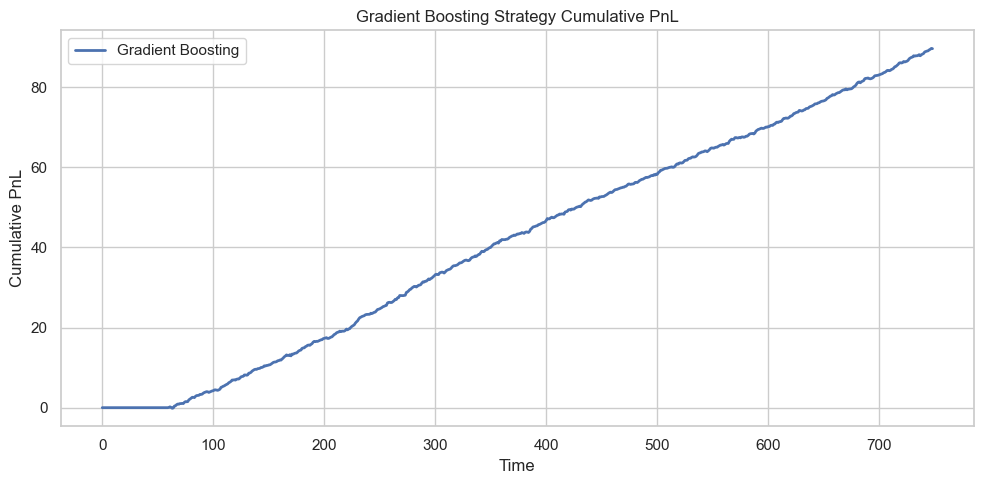

Gradient Boosting: (89.6483135852508, 0.11969067234345898, 0.14304752003282303, 13.282512826601128, 0.3490883702513443)


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and transpose price data
data = np.loadtxt("prices.txt", dtype=float).T
n_assets, n_obs = data.shape

# Compute log returns and correlation matrix
returns = np.diff(np.log(data), axis=1)
cor_matrix = np.corrcoef(returns)

def top_corr(cor_mat, top_n=10):
    n = cor_mat.shape[0]
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append(((i, j), cor_mat[i, j]))
    pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
    return pairs[:top_n]

top_pairs = top_corr(cor_matrix, top_n=10)
pair_indices = [pair for pair, _ in top_pairs]
min_len = min([len(data[i]) for i, j in pair_indices])

def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def evaluate(pnl):
    cum_pnl = np.cumsum(pnl)
    avg_daily_return = pnl.mean()
    volatility = pnl.std()
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
    max_drawdown = (np.maximum.accumulate(cum_pnl) - cum_pnl).max()
    return cum_pnl[-1], avg_daily_return, volatility, sharpe_ratio, max_drawdown

def generate_features_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []
    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0
        forward_return = spread[t + 5] - spread[t]
        label = 1 if forward_return > 0.002 else -1 if forward_return < -0.002 else 0
        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band, vol_regime
        ]
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y), spread, z

def run_gradient_boosting(pair_indices):
    ensemble_positions = np.zeros(min_len - 1)
    for i, j in pair_indices:
        p1, p2 = data[i][:min_len], data[j][:min_len]
        X, y, spread, z = generate_features_labels(p1, p2)
        clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
        clf.fit(X, y)
        positions = [0] * 60
        for t in range(60, len(z) - 1):
            spread_window = spread[t - 20:t]
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            upper_band = mean + 2 * std
            lower_band = mean - 2 * std
            momentum_3 = spread[t] - spread[t - 3]
            momentum_5 = spread[t] - spread[t - 5]
            long_vol = np.std(spread[t - 40:t])
            short_vol = np.std(spread[t - 10:t])
            vol_regime = 1 if short_vol > long_vol else 0
            test_feat = [
                z[t], mean, std, momentum_3, momentum_5,
                spread[t] - spread[t - 1], upper_band - spread[t],
                spread[t] - lower_band, vol_regime
            ]
            pred = clf.predict([test_feat])[0]
            positions.append(pred)
        positions = np.array(positions[:len(spread) - 1])
        spread_diff = np.diff(spread)
        pnl = positions * spread_diff
        ensemble_positions[:len(pnl)] += pnl
    return ensemble_positions / len(pair_indices)

# Run only Gradient Boosting
pnl_gb = run_gradient_boosting(pair_indices)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pnl_gb), label="Gradient Boosting", linewidth=2)
plt.title("Gradient Boosting Strategy Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
print("Gradient Boosting:", evaluate(pnl_gb))


Stacking ensemble with XGboost

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Generate features and labels
def generate_features_labels(p1, p2, window=10):
    spread = p2 - np.polyfit(p1, p2, 1)[0] * p1
    z = (spread - pd.Series(spread).rolling(window).mean()) / pd.Series(spread).rolling(window).std()
    df = pd.DataFrame({
        'spread': spread,
        'z': z,
        'momentum': pd.Series(spread).diff(),
        'volatility': pd.Series(spread).rolling(5).std(),
        'boll_upper': pd.Series(spread).rolling(5).mean() + 2 * pd.Series(spread).rolling(5).std(),
        'boll_lower': pd.Series(spread).rolling(5).mean() - 2 * pd.Series(spread).rolling(5).std(),
    }).dropna()
    df['label'] = np.sign(df['spread'].shift(-1) - df['spread'])
    df = df.dropna()
    return df.drop('label', axis=1), df['label'], df['spread'], df['z']

# Define label maps
label_map_full = {-1: 0, 0: 1, 1: 2}
reverse_map_full = {0: -1, 1: 0, 2: 1}
label_map_binary = {-1: 0, 1: 1}
reverse_map_binary = {0: -1, 1: 1}

# Use price data from previous uploads
d = np.loadtxt("prices.txt").T
returns = np.diff(np.log(d), axis=1)
cor_matrix = np.corrcoef(returns)
top_pairs = sorted([((i, j), cor_matrix[i, j]) for i in range(len(cor_matrix)) for j in range(i+1, len(cor_matrix))],
                   key=lambda x: abs(x[1]), reverse=True)[:5]
valid_top_pairs = [pair[0] for pair in top_pairs]
prices_30 = d[:, -300:]

results = {}

# Iterate over top pairs
for i, j in valid_top_pairs:
    p1, p2 = prices_30[i], prices_30[j]
    X, y, spread, z = generate_features_labels(p1, p2)

    if y.value_counts().get(0, 0) < 5:
        y = y[y != 0]
        X = X.loc[y.index]
        y = y.map(label_map_binary)
        reverse_map = reverse_map_binary
    else:
        y = y.map(label_map_full)
        reverse_map = reverse_map_full

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, verbosity=0, use_label_encoder=False)
    model.fit(X_train_scaled, y_train)

    # Predict
    preds = model.predict(X_test_scaled)
    preds_final = np.vectorize(reverse_map.get)(preds)
    y_test_final = np.vectorize(reverse_map.get)(y_test)

    # PnL calculation
    spread = spread.iloc[-len(y_test_final):].reset_index(drop=True)
    spread_diff = spread.diff().fillna(0).values
    pnl = preds_final[:-1] * spread_diff[1:]
    cumulative_pnl = np.cumsum(pnl)

    # Metrics
    sharpe = pnl.mean() / pnl.std() * np.sqrt(252) if pnl.std() > 0 else 0
    max_dd = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()
    report = classification_report(y_test_final, preds_final, zero_division=0, output_dict=True)

    results[(i, j)] = {
        'pnl': cumulative_pnl,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'report': report
    }

    # Plot
    plt.plot(cumulative_pnl, label=f"Pair ({i},{j})")

plt.title("Cumulative PnL: XGBoost Pairs")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'xgboost'